In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2, glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
cars = glob.glob('../Data/vehicles_smallset/cars1/*.jpeg') + glob.glob('../Data/vehicles_smallset/cars2/*.jpeg') + glob.glob('../Data/vehicles_smallset/cars3/*.jpeg')
non_cars = glob.glob('../Data/non-vehicles_smallset/notcars1/*.jpeg') + glob.glob('../Data/non-vehicles_smallset/notcars2/*.jpeg') + glob.glob('../Data/non-vehicles_smallset/notcars3/*.jpeg')

In [4]:
def get_random_image(location_array):
    return mpimg.imread(location_array[np.random.randint(0, len(location_array))])

In [5]:
sample_car_image = get_random_image(cars)
sample_non_car_image = get_random_image(non_cars)

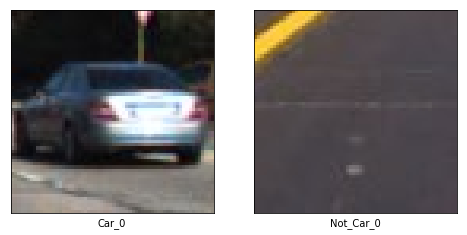

In [6]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(sample_car_image)
        ax.set_xlabel('Car_' + str(c))
    if i % 2 == 1:
        ax.imshow(sample_non_car_image)
        ax.set_xlabel('Not_Car_' + str(c))
        c += 1
plt.show()

In [7]:
def flattened_color_features(image, size = (32, 32)):
    return cv2.resize(image, size).ravel()

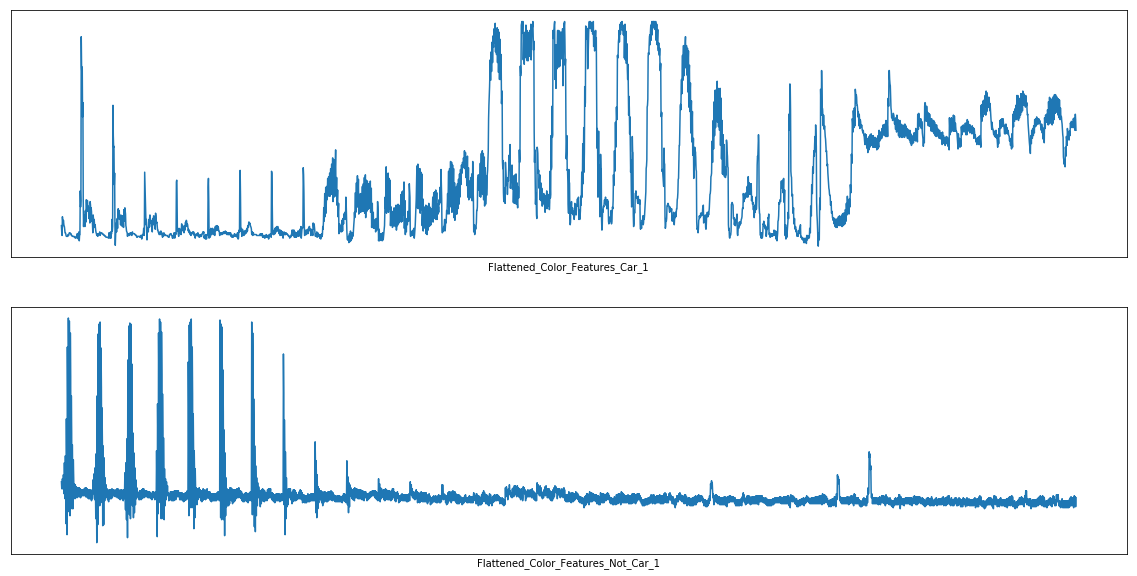

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(flattened_color_features(sample_car_image))
        ax.set_xlabel('Flattened_Color_Features_Car_' + str(c))
    if i == 1:
        ax.plot(flattened_color_features(sample_non_car_image))
        ax.set_xlabel('Flattened_Color_Features_Not_Car_' + str(c))
plt.show()

In [9]:
def get_histogram_features(image, bins = 32, _range = (0, 256)):
    channel_1_histogram = np.histogram(image[:, :, 0], bins = bins, range = _range)
    channel_2_histogram = np.histogram(image[:, :, 1], bins = bins, range = _range)
    channel_3_histogram = np.histogram(image[:, :, 2], bins = bins, range = _range)
    histogram_features = np.concatenate((channel_1_histogram[0], channel_1_histogram[0], channel_1_histogram[0]))
    return histogram_features

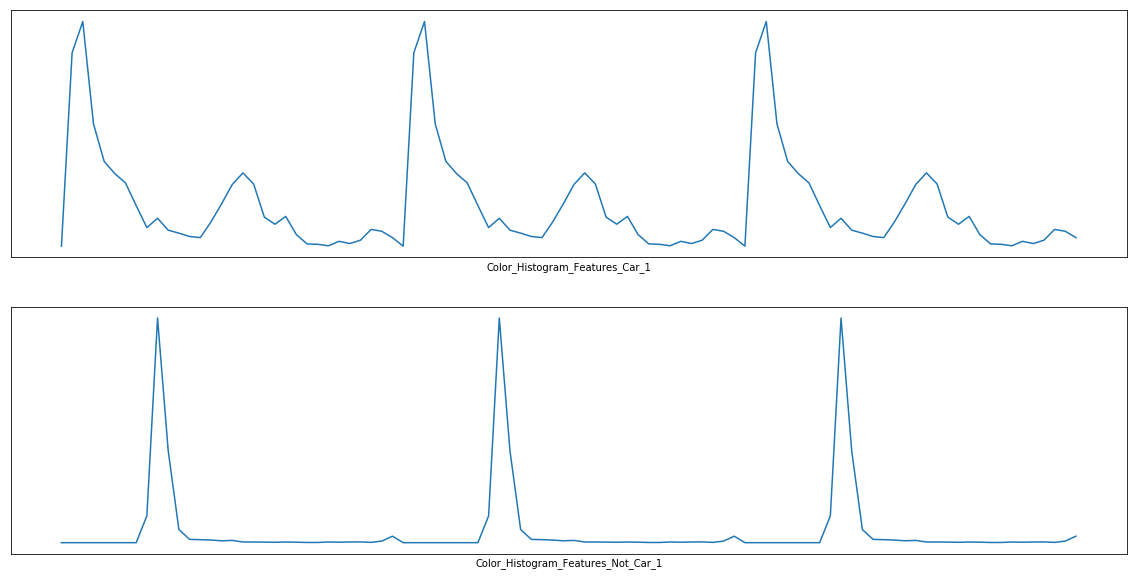

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(get_histogram_features(sample_car_image))
        ax.set_xlabel('Color_Histogram_Features_Car_' + str(c))
    if i == 1:
        ax.plot(get_histogram_features(sample_non_car_image))
        ax.set_xlabel('Color_Histogram_Features_Not_Car_' + str(c))
plt.show()

In [11]:
def get_features(image, colorspace = 'RGB', size = (32, 32), bins = 32, _range = (0, 256)):
    if colorspace == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif colorspace == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif colorspace == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif colorspace == 'RGB' or colorspace == 'BGR':
        feature_image = np.copy(image)
    flattend_spatial_features = flattened_color_features(feature_image, size)
    histogram_features = get_histogram_features(feature_image, bins, _range)
    features = np.concatenate((flattend_spatial_features, histogram_features))
    return features

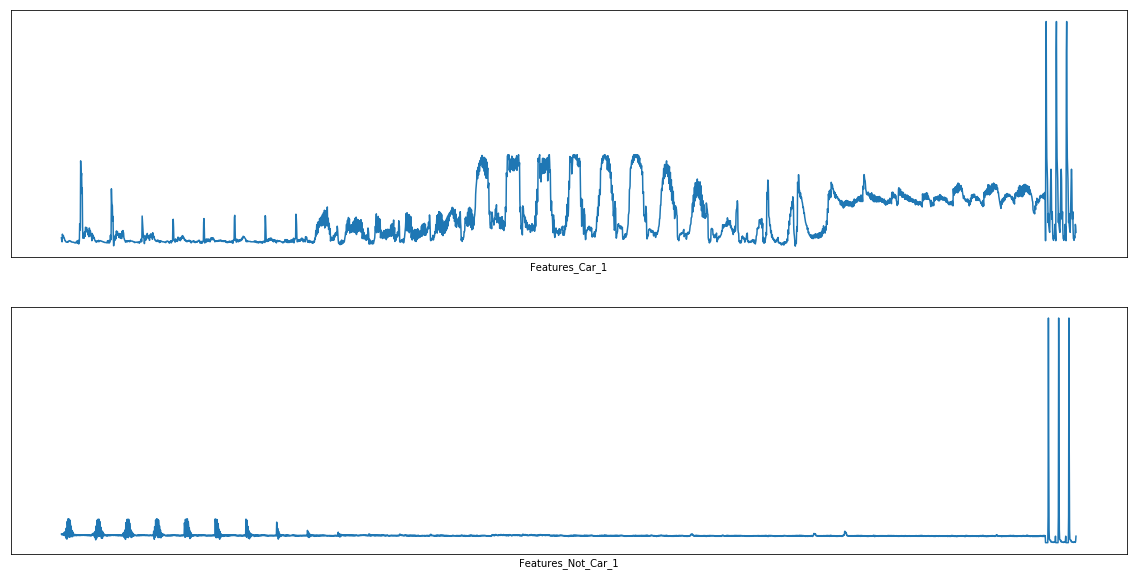

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(get_features(sample_car_image))
        ax.set_xlabel('Features_Car_' + str(c))
    if i == 1:
        ax.plot(get_features(sample_non_car_image))
        ax.set_xlabel('Features_Not_Car_' + str(c))
plt.show()